In [2]:
%load_ext autoreload
%aimport pyhipp

In [3]:
import numpy as np, pandas as pd
from pyhipp.io.excel import Excel
from pyhipp import plot
from pyhipp.astro import plot as a_plot
from pyhipp import stats

# to be compatible with Nature style
plot.runtime_config.use_stylesheets('mathtext-it')
plot.abc.mpl.rc('mathtext', fontset='dejavusans')   
plot.abc.mpl.rc('axes', grid=False)

# color sequences
cs_dark2 = plot.ColorSeq.predefined('dark2').get_rgba()
cs_set1 = plot.ColorSeq.predefined('set1').get_rgba()
cs_set2 = plot.ColorSeq.predefined('set2').get_rgba()
cs_tab10 = plot.ColorSeq.predefined('tab10').get_rgba()

## Fig. 2

In [4]:
d_plts = Excel.load_file('Fig2.xlsx')

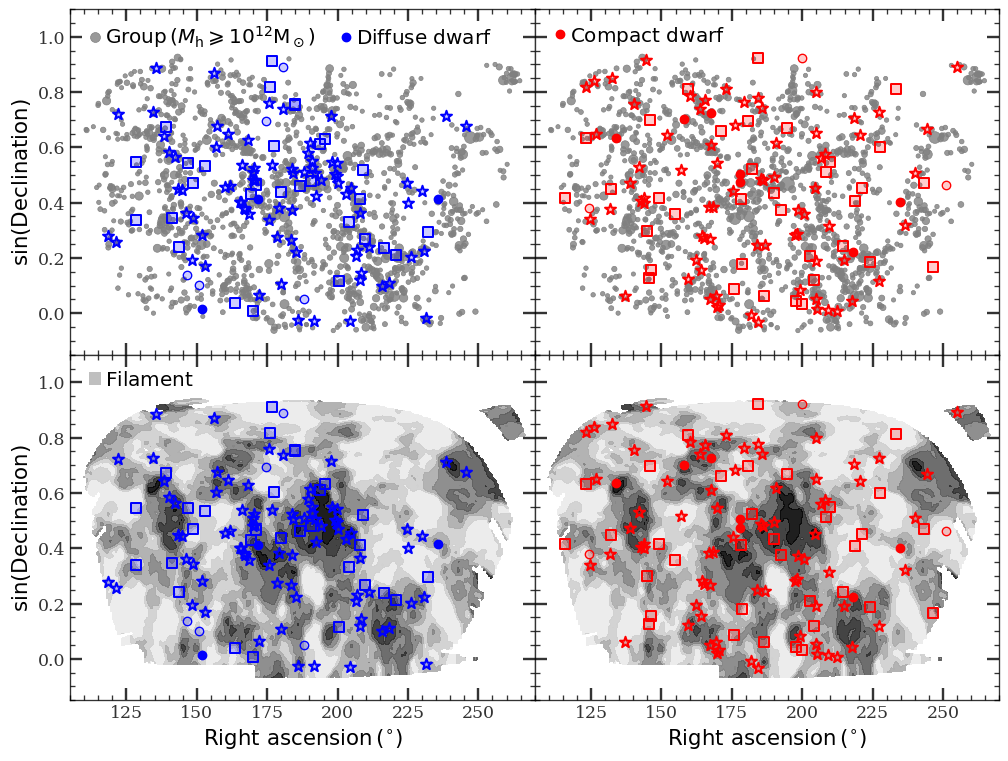

In [11]:
fig, axs = plot.subplots((2,2), share=True, space=0, subsize=(5.5, 4.5), 
                         margin=[0.1, 0.02, 0.1, 0.1], layout='none')
axs_f = axs.flat
for i_c in range(2):
    ax = axs[0, i_c]
    x, y, s = d_plts['group'][['RA', 'sin_Dec', 'marker_size']].to_numpy().T
    lab = r'${\rm Group}\,(M_{\rm h} \geqslant 10^{12}{\rm M}_\odot)$' if i_c == 0 else None
    ax.fmt_marker(c='grey', ea=1., fa=.8, elw=.5).scatter(x, y, s=s, label=lab, rasterized=True)
    
    ax = axs[1, i_c]
    x, y = d_plts['grids'][['RA', 'sin_Dec']].to_numpy().T
    shape = (x.size, y.size)
    f_fil = d_plts['fields']['frac_filament'].to_numpy().reshape(shape)
    mask = d_plts['fields']['reconstruction_mask'].to_numpy().reshape(shape)
    f_fil = np.ma.array(f_fil, mask=~mask)
    
    ax._raw.contourf(x, y, f_fil.T, cmap='Greys', vmin=-.1, vmax=1., alpha=.9)
    
axs[1,0].fmt_marker(c='grey', fa=.5).scatter(
    [-100], [-100.], edgecolors='none', marker='s', label=r'$\rm Filament$')
    
cs_samp = 'b', 'r'
labs = r'$\rm Diffuse\ dwarf$', r'$\rm Compact\ dwarf$'
for i_r in range(2):
    for i_samp, samp in enumerate(['diffuse', 'compact']):
        ax = axs[i_r, i_samp]
        x, y, web_t = d_plts[samp][['RA', 'sin_Dec', 'web_type']].to_numpy().T
        sel0, sel1, sel2, sel3 = [web_t == i for i in range(4)]
        lab = labs[i_samp] if i_r == 0 else None
        ax.fmt_marker(c=cs_samp[i_samp], ea=1, fa=0.2, elw=1.5)\
            .scatter(x[sel2], y[sel2], s=75, marker='*', zorder=100)\
            .scatter(x[sel1], y[sel1], s=50, marker='s', zorder=100)\
            .fmt_marker(elw=1).scatter(x[sel0], y[sel0], s=40, marker='o', zorder=100)\
            .fmt_marker(fa=1).scatter(x[sel3], y[sel3], s=40, marker='o', zorder=100, label=lab)
        #ax.scatter([], [], label=lab, s=0)
        
axs.lim([105, 270], [-0.15, 1.1]).label(r'\rm Right\ ascension\,(^{\circ})', r'\sin(\rm Declination)').label_outer()
kw=dict(scatterpoints=1, ncol=3, handletextpad=0, loc='ul', handlelength=1, handleheight=1)
axs_f[:2].leg(**kw)
axs_f[2].leg(**kw, markerscale=3)

plot.savefig('Fig2-left.pdf')

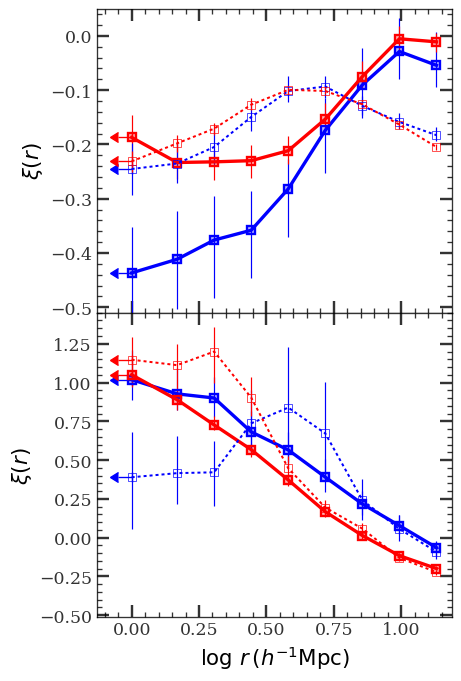

In [10]:
fig, axs = plot.subplots((2,1), share=(True, 'row'), space=0, 
                         subsize=(4.75, 3.5), margin=[0.02, 0.02, 0.075, .2], layout='none')
axs_f = axs.flat

corrs = d_plts['2pccfs']

web_types = ['void', 'sheet', 'filament', 'knot']
y_lims = [-.51, 0.05], [-0.51, 1.45] 
to_axs = 0,0, 1,1

lws = (2.5, 1.5)*2
lss = ('-', (0,(1.5,1.5)))*2
mews = (1.75,0.5)*2
fas = (.3,0)*4
cs = 'b', 'r'

for i_t, web_type in enumerate(web_types):
    eb_kw = dict(capsize=0, elinewidth=.9, capthick=0, marker='s', 
                 ms=6., mew=mews[i_t])
    ax = axs_f[to_axs[i_t]]
    ax.fmt_marker(fa=fas[i_t])
    for i_sub, sub_key in enumerate(['diffuse', 'compact']):
        ax.c(cs[i_sub])
        x, y, e_lo, e_hi = corrs[f'{sub_key}_and_{web_type}'][
            ['log_r', 'xi', 'err_lo', 'err_up']].to_numpy().T
        x = x.clip(0.)
        ax.errorbar(x, y, yerr=(e_lo, e_hi), **eb_kw, lw=lws[i_t], 
                    ls=lss[i_t])
        
        ax.errorbar(x[[0]], y[[0]], xerr=0.05, xuplims=True)

axs.label(r'\log\,r\,(h^{-1}{\rm Mpc})', r'\xi(r)').label_outer()
axs.lim([-0.13, 1.19]).label_outer()

for i, ax in enumerate(axs):
    ax.lim(y=y_lims[i])
    
plot.savefig('Fig2-right.pdf')

## Fig. 3

In [8]:
d_plts = Excel.load_file('Fig3.xlsx')

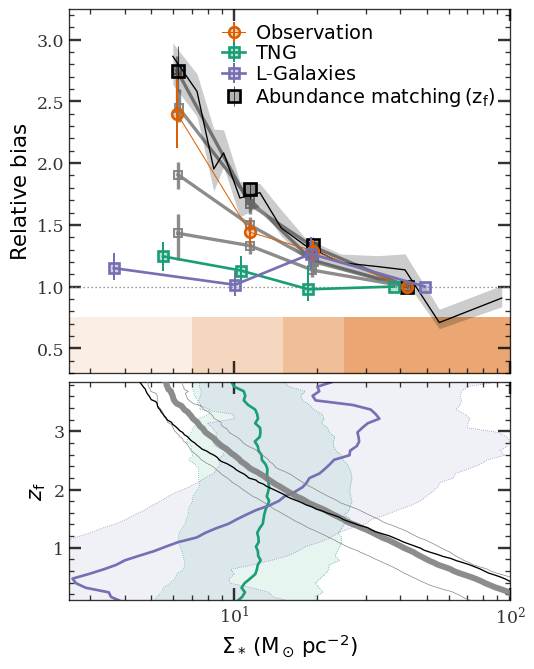

In [9]:
fig, axs = plot.subplots((2,1), share=(True, False),
    space=0.03, subsize=(5.5, 3.5), 
    margin=[0.02, 0.03, 0.1, 0.135], layout='none',
    ratios=(None, [2, 1.2]))
axs_f = axs.flat

ax = axs_f[0]
d_pan_a = d_plts['panel_a']
cols = ['Sigma', 'bias', 'err_lo', 'err_up']

mss = 8,7,7
cs = cs_dark2[1], cs_dark2[0], cs_dark2[2]
lws = .75, 2., 2.
labs = r'$\rm Observation$', r'$\rm TNG$', r'$\rm L$-$\rm Galaxies$'
mks =   'o', 's', 's'
for i, k in enumerate(('obs', 'tng', 'lgal')):
    x, y, el, eh = d_pan_a[k][cols].to_numpy().T
    ax.c(cs[i]).errorbar(x, y, yerr=(el, eh), lw=lws[i], marker=mks[i], 
                           mew=2, ms=mss[i], capsize=0, elinewidth=1.5, 
                           label=labs[i], zorder=10)

ax.c('k')
x, y, el, eh = d_pan_a['rho1p00'][cols].to_numpy().T
ax.errorbar(x, y, yerr=(el, eh), lw=0, marker='s', 
                    mew=2, ms=9, capsize=0, elinewidth=.5,
                    label=r'$\rm Abundance\ matching\,(z_{\rm f})$', zorder=9)
x, y, el, eh = d_pan_a['rho1p00_fine_bin'][cols].to_numpy().T
ax.errorfill(x, y, yerr=(el, eh), lw=1., ls='-',
             fill_between_kw={'lw': 0., 'alpha': .2}, zorder=9
             )
        
ax.c('grey')
for i_k, k in enumerate(['rho0p90', 'rho0p85', 'rho0p80', 'rho0p50']):
    x, y, el, eh = d_pan_a[k][cols].to_numpy().T
    ax.c('grey', a=.9).fmt_marker(fa=.1)
    ax.errorbar(x, y, yerr=(el, eh), lw=2.5, capsize=0,
                elinewidth=2.5, marker='s', ms=6.5, zorder=-2, mew=1.5)

ax.scale(x='log').lim([10**0.4, 1.0e2], [0.3, 3.25])
ax.label(y = r'{\rm Relative\ bias}')
ax.leg(loc='ur', #labelcolor='linecolor', 
       handlelength=1.2, numpoints=1, fontsize=14.5)\
    .plot([1.0e-10, 1000.], [1., 1.], c='grey', lw=1, ls=(0,(1,2)))

obs_lims = 1.0e-3, 7., 15., 25., 1.0e3
cs = (cs_dark2[1],)*5
for i in range(4):
    x = [obs_lims[i], obs_lims[i+1]]
    y1 = np.array([-1., -1.])
    y2 = y1 + 1.75
    ax.fill_between(x, y1, y2, color=cs[i], lw=0, alpha=.1+.15*i, zorder=-2)

ax = axs_f[1]
d_pan_b = d_plts['panel_b'] 
cols = ['Sigma', 'z_f', 'xerr_lo', 'xerr_up']

xp, yp, el, eh = d_pan_b['rho0p85'][cols].to_numpy().T
ax.plot(xp, yp, lw=4.5, zorder=3, c='grey', alpha=.9)
ax.plot(xp-el, yp, lw=.5, zorder=3, c='grey')
ax.plot(xp+el, yp, lw=.5, zorder=3, c='grey')
        
xp, yp = d_pan_b['rho1p00'][['Sigma', 'z_f']].to_numpy().T
ax.plot(xp, yp, lw=1., zorder=3, c='k')

cs = cs_dark2[0], cs_dark2[2]
for i_k, key in enumerate(['tng', 'lgal']):
    ax.c(cs[i_k])
    x, y, el, eh = d_pan_b[key][cols].to_numpy().T
    ax.plot(x, y, lw=2.)
    ax.plot(x-el, y, lw=.5, ls=(0,(1,2)))
    ax.plot(x+eh, y, lw=.5, ls=(0,(1,2)))
    ax._raw.fill_betweenx(y, x-el, x+eh, color=cs[i_k], 
                          alpha=.1, lw=0, zorder=-10)

ax.lim(y=[0.1, 3.85])\
    .label(r'\Sigma_*\,({\rm M}_\odot\,{\rm pc}^{-2})', r'z_{\rm f}')

plot.savefig('Fig3-ab.pdf')

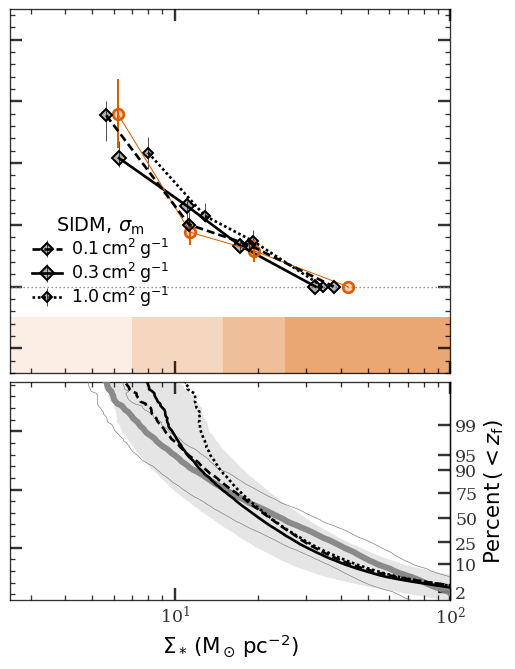

In [10]:
fig, axs = plot.subplots((2, 1), share=(True, False),
                         space=0.03, subsize=(5.5, 3.5),
                         margin=[0.02, 0.135, 0.1, 0.03], layout='none',
                         ratios=(None, [2, 1.2]))
axs_f = axs.flat

ax = axs_f[0]
d_pan_a = d_plts['panel_a']
cols = ['Sigma', 'bias', 'err_lo', 'err_up']


mss = 8,
cs = cs_dark2[1],
lws = .75,
labs = None,  # r'$\rm Observation$',
mks = 'o',
for i, k in enumerate(('obs',)):
    x, y, el, eh = d_pan_a[k][cols].to_numpy().T
    ax.c(cs[i]).errorbar(x, y, yerr=(el, eh), lw=lws[i], marker=mks[i],
                         mew=2, ms=mss[i], capsize=0, elinewidth=1.5,
                         label=labs[i], zorder=10)

lws = (2., )*4
lss = (0, (3, 1.5)), '-', (0, (1, 1)), '-'
ax.c('k')
zods = 11, 9, 8
mss = 6, 7, 5
for i, (sig_val, sig) in enumerate([(0.10, '0p1'),
                                    (0.30, '0p3'),
                                    (1.00, '1p0')]):
    x, y, el, eh = d_plts['panel_c'][f'sigma_m_{sig}'][cols].to_numpy().T
    # lab = r'${\rm SIDM}$' if i == 1 else None
    lab = r'$%.1f\,{\rm cm^2\,g^{-1}}$' % (sig_val)
    ax.errorbar(x, y, yerr=(el, eh), lw=lws[i], ls=lss[i], marker='D',
                mew=1.5, ms=mss[i], capsize=0, elinewidth=.5,
                label=lab, zorder=zods[i])

ax.scale(x='log').lim([10**0.4, 1.0e2], [0.3, 3.25])
# ax.label(y = r'{\rm Relative\ bias}')
ax.leg(loc=(.04, .165),  # labelcolor='linecolor',
       handlelength=1.75, numpoints=1, fontsize=13., title_fontsize=14.5,
       labelspacing=0.,
       title=r'${\rm SIDM},\,\sigma_{\rm m}$')\
    .plot([1.0e-10, 1000.], [1., 1.], c='grey', lw=1, ls=(0, (1, 2)))
ax._raw.set_yticklabels([])

obs_lims = 1.0e-3, 7., 15., 25., 1.0e3
cs = (cs_dark2[1],)*5
for i in range(4):
    x = [obs_lims[i], obs_lims[i+1]]
    y1 = np.array([-1., -1.])
    y2 = y1 + 1.75
    ax.fill_between(x, y1, y2, color=cs[i], lw=0, alpha=.1+.15*i, zorder=-2)

ax = axs_f[1]
d_pan_b = d_plts['panel_b']
cols = ['Sigma', 'z_f', 'xerr_lo', 'xerr_up']

xp, yp, el, eh = d_pan_b['rho0p85'][cols].to_numpy().T
ax.plot(xp, yp, lw=4.5, zorder=3, c='grey', alpha=.9)
ax.plot(xp-el, yp, lw=.5, zorder=3, c='grey')
ax.plot(xp+el, yp, lw=.5, zorder=3, c='grey')

lws = (2., )*4
lss = (0, (3, 1.5)), '-', (0, (1, 1)), '-'
ax.c('k')
_as = .1, .1, .1
for i, (sig_val, sig) in enumerate([(0.10, '0p1'),
                                    (0.30, '0p3'),
                                    (1.00, '1p0')]):
    xp, yp, el, eh = d_plts['panel_d'][f'sigma_m_{sig}'][cols].to_numpy().T
    ax.plot(xp, yp, lw=lws[i], ls=lss[i], zorder=3)
    if i != 1:
        continue
    ax._raw.fill_betweenx(yp, xp-el, xp+eh, color='k',
                          alpha=_as[i], lw=0, zorder=-10)

y = d_pan_b['rho1p00_sample']['z_f']
_ly = np.log10(1. + y)
_y = 10.0 ** stats.RandomNoise(.001).add_to(_ly) - 1.
trans = stats.prob_dist.ProbTransToNorm(_y)
def fn1(_x): return trans.CDF_x(_x) * 100.
def fn2(_x): return trans.invCDF_x((_x/100.).clip(0., 1.))


s_ax = a_plot.Axes(ax).add_secondary_axis(fn1, fn2, location='right')
s_ax._raw.set_yticks([2., 10, 25, 50, 75, 90, 95, 99])
s_ax._raw.tick_params(axis='y', which='minor', left=False, right=False)
s_ax.label(y=r'{\rm Percent}\, (< z_{\rm f})')

ax.lim(y=[0.1, 3.85])\
    .label(r'\Sigma_*\,({\rm M}_\odot\,{\rm pc}^{-2})',
           # r'z_{\rm f}'
           )
ax._raw.set_yticklabels([])

plot.savefig('Fig3-cd.pdf')

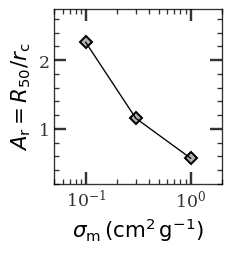

In [12]:
fig, ax = plot.subplots(1, figsize=2.5, 
    margin=[0.05, 0.05, 0.22, 0.25], layout='none')

x, y = d_plts['panel_c_inset'][['sigma', 'A_r']].to_numpy().T

ax.plot(x, y, marker='D', ms=6, lw=1., mew=1.5)

ax.scale('log').lim([0.05, 2.], [0.2, 2.75])\
    .label(x=r'\sigma_{\rm m}\,{\rm (cm^2\,g^{-1})}', y=r'A_{\rm r}=R_{50}/r_{\rm c}')
    
plot.savefig('Fig3-c-inset.pdf')

## Fig. 4

In [27]:
d_plts = Excel.load_file('Fig4.xlsx')

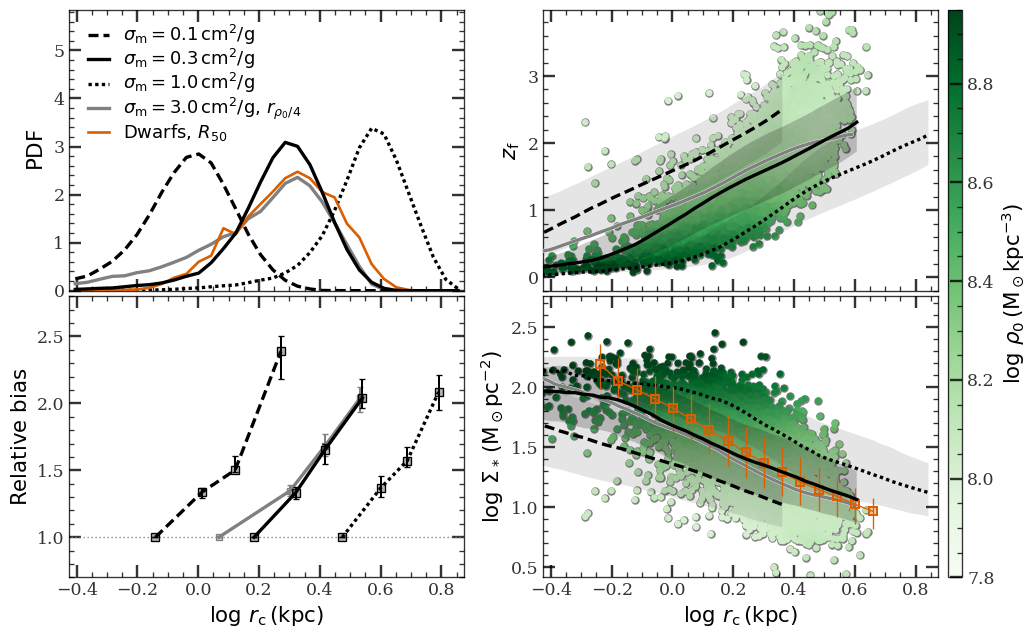

In [28]:
fig, axs = plot.subplots(
    (2, 2),
    share=(False, False),
    space=(0.2, .02),
    figsize=(11., 6.5),
    margin=[0.01, 0.01, 0.08, 0.065],
    layout='none')
axs = axs.flat[[0, 2, 1, 3]]

x_lim = [-.425, 0.875]

lws = 2.5, 2.5, 2.5, 2.5
lss = (0, (3, 1.5)), '-', (0, (1, 1)), '-'
sigs = 0.1, 0.3, 1.0, 3.0
c_outs = 'k', 'k', 'k', 'grey'
mss = 6., 6., 6., 5.
_as = .1, .2, .1, 0.
key_outs = 'sigma_m_0p1', 'sigma_m_0p3', 'sigma_m_1p0', 'sigma_m_3p0'
zorders = 20, 22, 18, 17

for i_k, key_out in enumerate(key_outs):
    c_out = c_outs[i_k]

    ax = axs[0]
    if i_k < 3:
        lab = r'$\sigma_{\rm m} = %.1f\,{\rm cm^2/g}$' % (sigs[i_k])
    else:
        lab = r'$\sigma_{\rm m} = %.1f\,{\rm cm^2/g},\,r_{\rho_{\rm 0}/4}$' % (
            sigs[i_k])
    x, y = d_plts['panel_a'][key_out][['log_r', 'pdf']].to_numpy().T
    ax.plot(
        x, y, lw=lws[i_k],
        ls=lss[i_k],
        c=c_out, label=lab, zorder=zorders[i_k])

    ax = axs[1]
    x, y, el, eh = d_plts['panel_b'][key_out][
        ['log_r', 'bias', 'err_lo', 'err_up']].to_numpy().T
    ax.c(c_out).errorbar(
        x, y, yerr=(el, eh),
        lw=lws[i_k],
        marker='s', ms=mss[i_k],
        mew=1., ls=lss[i_k],
        capsize=2.5, elinewidth=1.5, zorder=zorders[i_k])

    for i_y, (y_k, pan) in enumerate([
        ('z_f', 'panel_c'), ('log_Sigma', 'panel_d')]):
        ax = axs[i_y+2]
        ax.c(c_out)
        x, y, el, eh = d_plts[pan]['curve'][key_out][
            ['log_r', y_k, 'err_lo', 'err_up']].to_numpy().T
        kw = {'zorder': zorders[i_k]}
        ax.errorfill(x, y, yerr=(el, eh), lw=lws[i_k], ls=lss[i_k],
                     fill_between_kw={'lw': 0., 'fc': (0, 0, 0, _as[i_k]),
                                      'ec': 'gray',
                                      'zorder': 8}, **kw)
        if i_k == 3:
            ax.plot(x, y, lw=3., c='w', zorder=zorders[i_k]-1)
        if i_k != 1:
            continue

        norm = plot.abc.mpl.colors.Normalize(7.8, 8.95)
        x, y, z = d_plts[pan]['scatter'][key_out][
            ['log_r', y_k, 'log_rho_0']].to_numpy().T
        ax.fmt_marker(elw=0, fa=1)
        ax.scatter(x, y, rasterized=True, zorder=1, c='grey', s=40)
        cb = ax.scatter(x, y, rasterized=True, zorder=2, c=z,
                        s=25, norm=norm, cmap='Greens').last_draw

fig.colorbar(cb, ax=axs, location='right', pad=0.01, aspect=40.,
             label=r'$\log\, \rho_0\,({\rm M_\odot kpc^{-3}})$')

ax = axs[0]
x, y = d_plts['panel_a']['obs'][['log_r', 'pdf']].to_numpy().T
ax.plot(x, y, lw=2, c=cs_dark2[1], zorder=21,
        label=r'${\rm Dwarfs},\,R_{\rm 50}$')

ax = axs[3]
x, y, el, eh = d_plts['panel_d']['obs'][
    ['log_r', 'log_Sigma', 'err_lo', 'err_up']].to_numpy().T
ax.c(cs_dark2[1]).fmt_marker(fa=.3, elw=1)\
    .errorbar(x, y, yerr=(el, eh), marker='s', mew=1.5, ms=5.5, capsize=0, lw=1,
              label=r'${\rm Dwarfs}\,(\Sigma_*)$', zorder=21)

axs[0].lim(x_lim, [0., 5.85]).label(y=r'\rm PDF')\
    .leg(loc='ul', 
         #labelcolor='linecolor', 
         fontsize=13.5,
         handlelength=1.75, labelspacing=0., ncol=1, columnspacing=0.5)
axs[1].scale().lim(x_lim, [0.7, 2.8])\
    .label(r'\log\,r_{\rm c}\,({\rm kpc})', r'{\rm Relative\ bias}')\
    .plot([-10., 10.], [1., 1.], c='grey', lw=1, ls=(0,(1,2)))
axs[2].lim(x_lim, [-.2, 3.99]).label(y=r'z_{\rm f}')
axs[3].lim(
    x_lim, [.415, 2.76]).label(
    r'\log\,r_{\rm c}\,({\rm kpc})', r'\log\,\Sigma_*\,({\rm M_\odot pc^{-2}})')
axs[0]._raw.set_xticklabels([])
axs[2]._raw.set_xticklabels([])

plot.savefig('Fig4.pdf')

## Extended Data Fig. 8

In [ ]:
d_plts = Excel.load_file('Wang_EDfig8.xlsx')

ps_obs = d_plts['percentiles']['percentiles'].to_numpy()
g_labs = [f'${p1*100:.1f}\%$-${p2*100.:.1f}\%$'
    for p1, p2 in zip(ps_obs[:-1], ps_obs[1:])]
cs_g = ['b', 'g', cs_set1[4], 'r'][::-1]

h_labs = [
    r'$11.0 \leqslant M_{\rm h} < 12.0$',
    r'$12.0 \leqslant M_{\rm h} < 13.0$',
    r'$13.0 \leqslant M_{\rm h}$'
]

cols = ['r', 'wp', 'wp_err_lo', 'wp_err_hi', 'ratio', 'ratio_err_lo', 'ratio_err_hi']

cs_g_val = 'b', 'g', cs_set1[4], 'r'
g_labs_val = [
    r'$0 \leqslant \Sigma_* < 7$',
    r'$7 \leqslant \Sigma_* < 15$',
    r'$15 \leqslant \Sigma_* < 25$',
    r'$25 \leqslant \Sigma_*$',
]

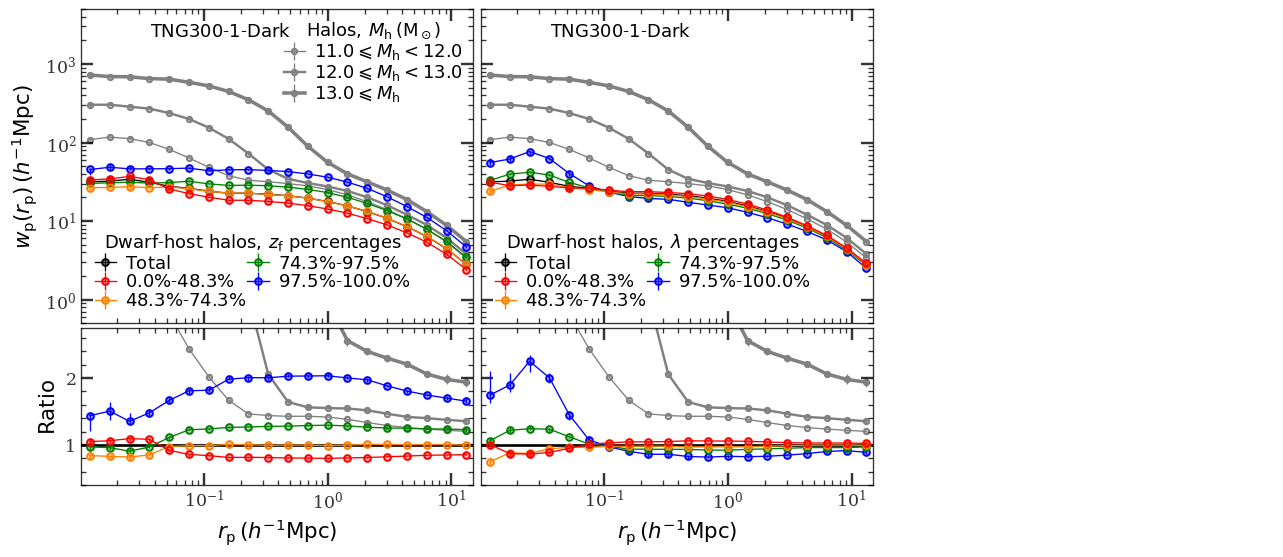

In [29]:
fig, axs = plot.subplots((2, 3), share=(True, 'row'),
    space=0.02, subsize=(4.5, 2.85), 
    margin=[0.02, 0.02, 0.11, 0.06], layout='none',
    ratios=(None, [2, 1.]))
axs[0,2].axis_off()
axs[1,2].axis_off()
axs = axs[:, :2]
axs_f = axs.flat

lws_h = np.linspace(1., 3.5, 4)
leg_kw = dict(title_fontsize=13.5, labelspacing=.05, columnspacing=.02,
              numpoints=1, 
              fontsize=13.5, 
              #labelcolor='linecolor', 
              handlelength=1.2)
key_labs = r'z_{\rm f}', r'\lambda'
for i_sim, pan in enumerate(['panel_a', 'panel_b']):
    d_pan = d_plts[pan]
    axs_c = axs[:, i_sim]
    ax, ax_r = axs_c
    
    kw = {'capsize': 0., 'lw': 1., 'mew': 1.5, 'marker': 'o', 'ms': 5.}
    x, y, y_el, y_eh, r, r_el, r_eh = d_pan['galaxy_all'][cols].to_numpy().T
    axs_c.c('k')
    label = r'$\rm Total$'
    ax.errorbar(x, y, yerr=(y_el, y_eh), zorder=-5, label=label, **kw)
    ax_r.plot([1.0e-10, 1.0e10], [1., 1.], zorder=-5, lw=2.)

    for i_sub, g_lab in enumerate(g_labs):    
        axs_c.c(cs_g[i_sub])
        x, y, y_el, y_eh, r, r_el, r_eh = d_pan[f'galaxy_sample_{i_sub}'][cols].to_numpy().T
        label = g_labs[i_sub]
        ax.errorbar(x, y, yerr=(y_el, y_eh), label=label, **kw, zorder=10-i_sub)
        ax_r.errorbar(x, r, yerr=(r_el, r_eh), **kw, zorder=10-i_sub)
        
    for i_sub, h_lab in enumerate(h_labs):
        axs_c.c('grey')
        x, y, y_el, y_eh, r, r_el, r_eh = d_pan[f'halo_sample_{i_sub}'][cols].to_numpy().T
        label = h_labs[i_sub] if i_sim == 0 else None
        kw = {
            'lw': lws_h[i_sub], 'zorder': -2, 'capsize': 0., 'elinewidth': 1.,
            'ms': 4, 'mew': 1.5, 'marker': 'o'
        }
        ax.errorbar(x, y, yerr=(y_el, y_eh), **kw)
        ax_r.errorbar(x, r, yerr=(r_el, r_eh), **kw, label=label)
    
    ax.leg(loc='ll',
           title=r'${\rm Dwarf}$-${\rm host\ halos},\,%s\ {\rm percentages}$'%(key_labs[i_sim]),
           **leg_kw, ncol=2)    

axs[0].scale('log', 'log').lim([1.02e-2, 15], [0.5, 5.0e3])
axs[1].lim(y=[0.4, 2.75])
axs[0,0].label(y=r'w_{\rm p}(r_{\rm p})\,(h^{-1}{\rm Mpc})')
axs[1,0].label(y=r'\rm Ratio').leg(loc=(.505, 2.4), 
    title=r'${\rm Halos},\,M_{\rm h}\, ({\rm M}_\odot)$', **leg_kw)
axs[1].label(r'r_{\rm p}\,(h^{-1}{\rm Mpc})')
axs.label_outer()

for i, ax in enumerate(axs[0]):
    ax.text(r'\rm TNG300$-$1$-$\rm Dark', (.175, .93), fontsize=13.5)
    
plot.savefig('Wang_EDfig8-ab.pdf')

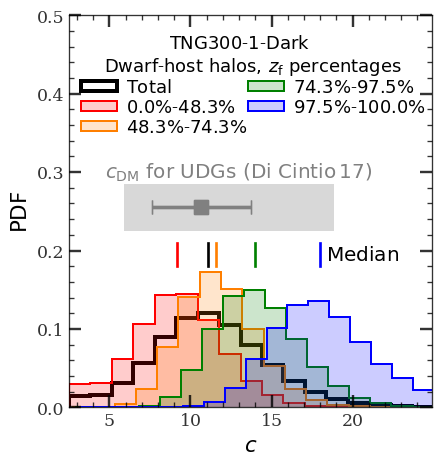

In [37]:
fig, ax = plot.subplots(1, figsize=(4.5, 4.75), 
                        margin=[0.03, 0.02, 0.11, 0.14], layout='none')


samp = d_plts['panel_c']['sample_total']
c_m = samp['median']['median'].to_numpy()[0]
c, pdf = samp['pdf'][['bin_center', 'pdf']].to_numpy().T
dc = c[1] - c[0]
e = np.concatenate([ c[[0]]-dc/2., c+dc/2. ])
ax.c('k').stairs(pdf, e, fc='none', label=r'$\rm Total$',lw=3.).plot([c_m, c_m], [.18, .21], lw=2.)

for i, g_lab in enumerate(g_labs):
    samp = d_plts['panel_c'][f'sample_{i}']
    c_m = samp['median']['median'].to_numpy()[0]
    c, pdf = samp['pdf'][['bin_center', 'pdf']].to_numpy().T
    dc = c[1] - c[0]
    e = np.concatenate([ c[[0]]-dc/2., c+dc/2. ])
    ax.c(cs_g[i]).stairs(pdf, e, lw=1.5, label=g_labs[i]).plot([c_m, c_m], [.18, .21], lw=2.)

ax.text(r'\rm Median', (.91, .39), ha='right')
ax.lim([2.51, 24.9], [0., .5]).label(r'c', r'\rm PDF').leg(loc=(.02, .68), 
    fontsize=13.5, columnspacing=0.02,
    title=r'${\rm Dwarf}$-${\rm host\ halos},\,z_{\rm f}\ {\rm percentages}$', title_fontsize=13.5, 
    ncol=2, 
    #labelcolor='mec'
    )
ax.text(r'\rm TNG300$-$1$-$\rm Dark', (.275, .93), fontsize=13.5)

x_med, x_sd, x_min, x_max = d_plts['panel_c']['NIHAO'][['median', 'stddev', 'min', 'max']].to_numpy().T
x_rg = np.concatenate([x_min, x_max])
ax.c('gray').fmt_marker('s', a=1)
ax.errorbar(x_med, [.255], xerr=[x_sd], elinewidth=2.5, capthick=2.5, capsize=5)
ax.errorbar(x_med, [.255], xerr=[x_sd], elinewidth=2.5, capthick=2.5, capsize=5)
ax.fill_between(x_rg, [.225]*2, [.285]*2, color='grey', alpha=.3, zorder=-100, lw=0)
ax.text(r'c_{\rm DM}\ {\rm for\ UDGs}\ {\rm (Di\ Cintio\,17)}', (.1, .6), color='grey')

plot.savefig('Wang_EDfig8-c.pdf')

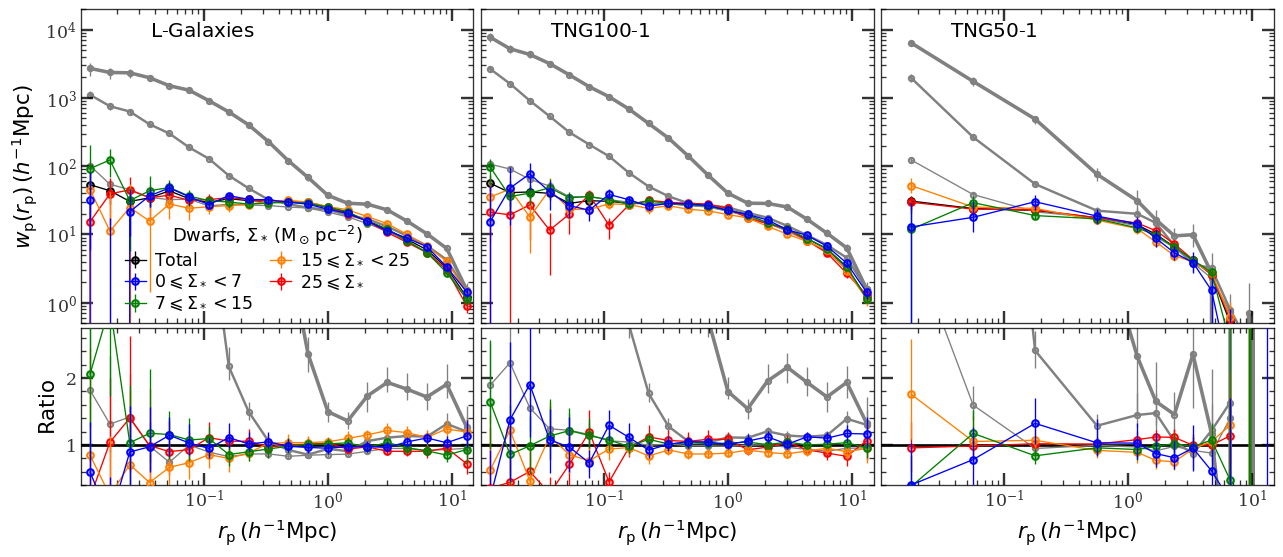

In [30]:
fig, axs = plot.subplots((2, 3), share=(True, 'row'),
    space=0.02, subsize=(4.5, 2.85), 
    margin=[0.02, 0.02, 0.11, 0.06], layout='none',
    ratios=(None, [2, 1.]))
axs_f = axs.flat


lws_h = np.linspace(1., 3.5, 4)

for i_sim, pan in enumerate(['panel_d', 'panel_e', 'panel_f']):
    d_pan = d_plts[pan]
    
    axs_c = axs[:, i_sim]
    ax, ax_r = axs_c
    
    kw = {'capsize': 0., 'lw': 1., 'mew': 1.5, 'marker': 'o', 'ms': 5.}
    
    x, y, y_el, y_eh, r, r_el, r_eh = d_pan['galaxy_all'][cols].to_numpy().T
    axs_c.c('k')
    label = r'$\rm Total$' if i_sim == 1 else None
    ax.errorbar(x, y, yerr=(y_el, y_eh), zorder=-5, label=label, **kw)
    ax_r.plot([1.0e-10, 1.0e10], [1., 1.], zorder=-5, lw=2.)
    
    for i_sub, g_lab in enumerate(g_labs_val):    
        axs_c.c(cs_g_val[i_sub])
        x, y, y_el, y_eh, r, r_el, r_eh = d_pan[f'galaxy_sample_{i_sub}'][cols].to_numpy().T
        label = g_labs_val[i_sub] if i_sim == 1 else None    
        ax.errorbar(x, y, yerr=(y_el, y_eh), label=label, **kw, zorder=10-i_sub)
        ax_r.errorbar(x, r, yerr=(r_el, r_eh), **kw, zorder=10-i_sub)
        
    for i_sub, h_lab in enumerate(h_labs):
        axs_c.c('grey')
        x, y, y_el, y_eh, r, r_el, r_eh = d_pan[f'halo_sample_{i_sub}'][cols].to_numpy().T
        kw = {
            'lw': lws_h[i_sub], 'zorder': -2, 'capsize': 0., 'elinewidth': 1.,
            'ms': 4, 'mew': 1.5, 'marker': 'o'
        }
        ax.errorbar(x, y, yerr=(y_el, y_eh), label=None, **kw)
        ax_r.errorbar(x, r, yerr=(r_el, r_eh), **kw)
    
axs[0].scale('log', 'log').lim([1.02e-2, 15], [0.5, 2.0e4])
axs[1].lim(y=[0.4, 2.75])
leg_kw = dict(title_fontsize=13.5, labelspacing=.2, numpoints=1, fontsize=13,
    #labelcolor='linecolor', 
handlelength=1.2)
axs[0,0].label(y=r'w_{\rm p}(r_{\rm p})\,(h^{-1}{\rm Mpc})')\
    .text(r'\rm L$-$\rm Galaxies', (.175, .93))
axs[0,1].leg(loc=(-.92, 0.02), title=r'${\rm Dwarfs},\,\Sigma_*\, ({\rm M}_\odot\,{\rm pc}^{-2})$',**leg_kw, ncol=2)
axs[1,0].label(y=r'\rm Ratio')
axs[0,1].text(r'\rm TNG100$-$1', (.175, .93))
axs[0,2].text(r'\rm TNG50$-$1', (.175, .93))
axs[1].label(r'r_{\rm p}\,(h^{-1}{\rm Mpc})')
axs.label_outer()

plot.savefig('Wang_EDfig8-def.pdf')